In [1]:
import pandas as pd
import os
import ast
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re 
from networkx.algorithms.community.quality import coverage, performance
import networkx.algorithms.community as nx_comm
from networkx.algorithms.centrality import edge_betweenness_centrality as edge_bet
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length as len_short_path
import numpy as np
import pprint
from typing import Dict
import json
from tqdm.notebook import tqdm
import community
# import nxmetis
import time
from math import ceil
from sklearn import metrics
pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 85)
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
import os
import nltk
from afinn import Afinn
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from collections import Counter
import itertools
from nltk.corpus import stopwords
import string
from nltk import wordpunct_tokenize
from nltk.stem.lancaster import LancasterStemmer
import networkx as nx
import re 
import pickle
from sklearn.preprocessing import MinMaxScaler
#import igraph as ig
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim
from nltk.stem import PorterStemmer 
from networkx.algorithms.centrality import degree_centrality
import random
np.random.seed(2018)
from gensim.models import CoherenceModel
# https://towardsdatascience.com/graph-algorithms-part-2-dce0b2734a1d
# https://github.com/taynaud/python-louvain/blob/master/community/community_louvain.py
# https://networkx.github.io/documentation/stable/_modules/networkx/algorithms/community/quality.html
# https://stackoverflow.com/questions/929103/convert-a-number-range-to-another-range-maintaining-ratio
from langdetect import detect

### Per aggiungere eventualmente altri dati

In [2]:
os.chdir('./data/vax_no_vax/Graph')

In [ ]:
multi = nx.read_gml('Graph/Final_MultiGraph_Covid.gml')

In [ ]:
print(nx.info(multi))

In [ ]:
graph = nx.read_gml('Graph/Final_Graph_Covid.gml')

In [ ]:
print(nx.info(graph))

In [ ]:
CG = nx.read_gml('Graph/Final_DiGraph_Covid.gml')

In [ ]:
print(nx.info(CG))

In [ ]:
new_data = pd.read_csv('./Dataset_marzo_JSON/slot3.csv')
new_data.dropna(axis='index', how='all', subset=['text'], inplace = True)

In [ ]:
new_data.shape

In [ ]:
language = list()
cont = 0
for _, row in tqdm(new_data.iterrows()):
    try:
        language.append(detect(row['text']))
    except:
        language.append('unknown')

In [ ]:
new_data['lang'] = language

In [ ]:
final_eng_march = new_data.query("lang == 'en'")

In [ ]:
final_eng_march.shape

In [ ]:
final_eng_march = final_eng_march.rename(columns={"lang": "language", "text": "text_con_hashtag" })

In [ ]:
def find_mentions(x):
    p = re.compile(r'@\s([^\s:]+)')
    return  ', '.join(p.findall(x))

def remove_mentions(x):
    p = re.sub(r'@\s([^\s:]+)', '', x)
    return p

final_eng_march["@mentions"] = final_eng_march["text_con_hashtag"].apply(find_mentions)
final_eng_march["text_con_hashtag"] = final_eng_march["text_con_hashtag"].apply(remove_mentions)
final_eng_march["@mentions"] = final_eng_march["@mentions"].str.lower()
final_eng_march["username"] = final_eng_march["username"].str.lower()

In [ ]:
final_eng_march = final_eng_march.drop_duplicates(subset=['text_con_hashtag', '@mentions', 'username', 'retweets', 'favorites'], keep='last')

In [ ]:
final_eng_march = final_eng_march[['username', 'favorites', 'retweets', 
        'language', '@mentions', 'geo', 'text_con_hashtag']]

In [ ]:
final_eng_march.head(5)

In [ ]:
final_eng_march.to_csv('./last_data.csv')

In [ ]:
result_sent_vax

In [3]:
with open('result_sent_vax', 'rb') as f:
    result_sent = pickle.load(f)
    
with open('result_no_sent_vax', 'rb') as f:
    result_no_sent = pickle.load(f)

In [ ]:
print(os.getcwd())

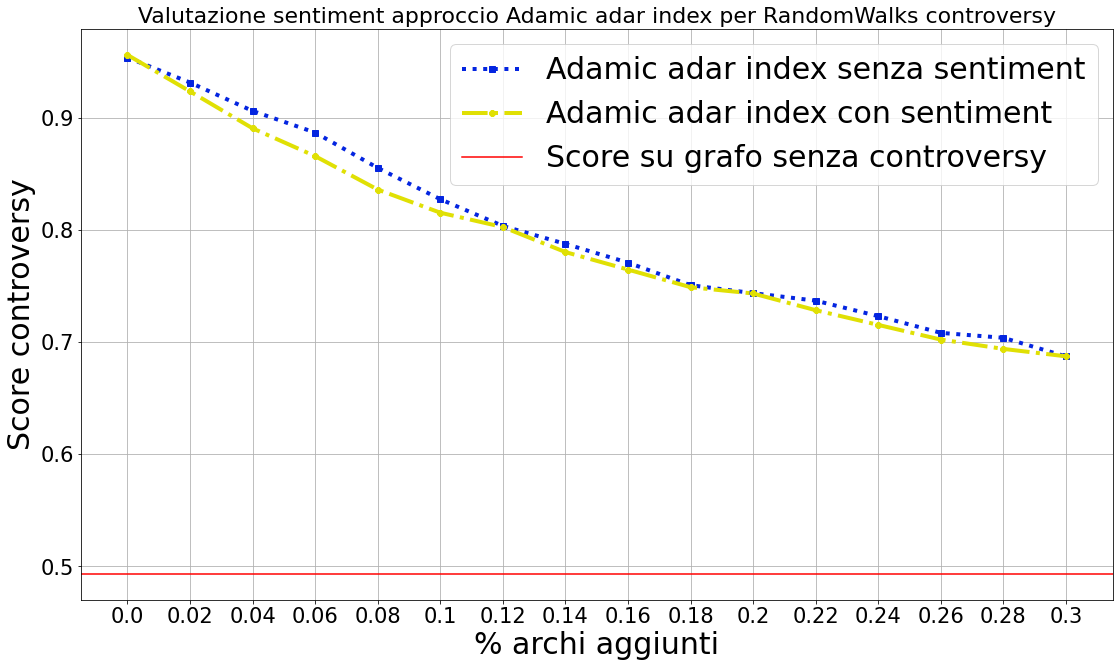

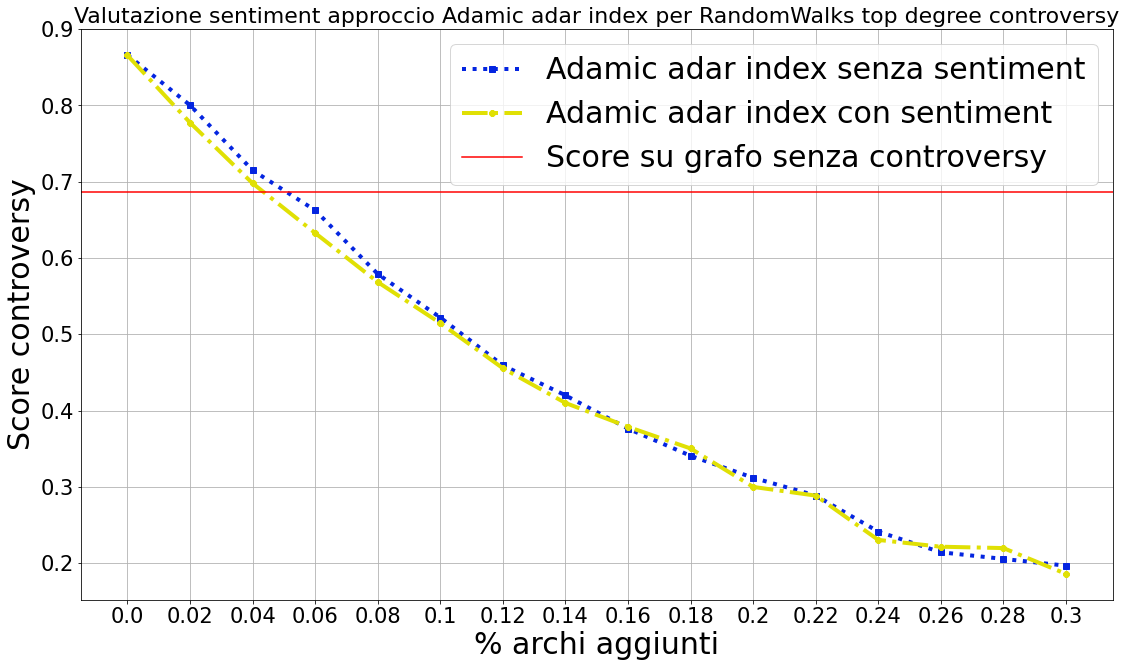

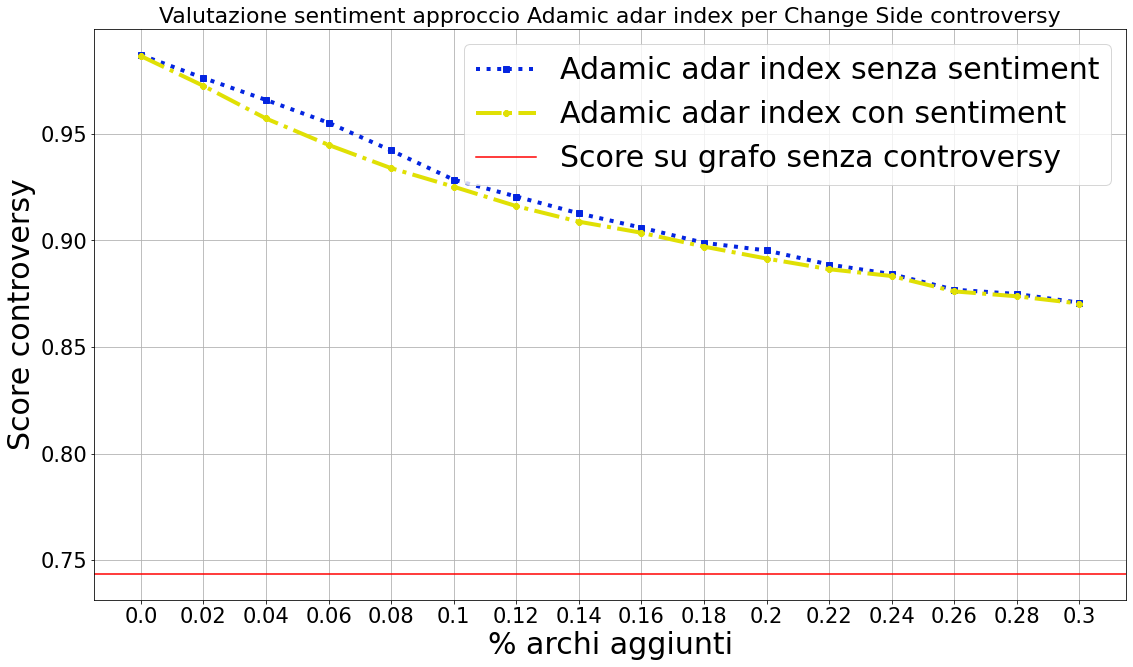

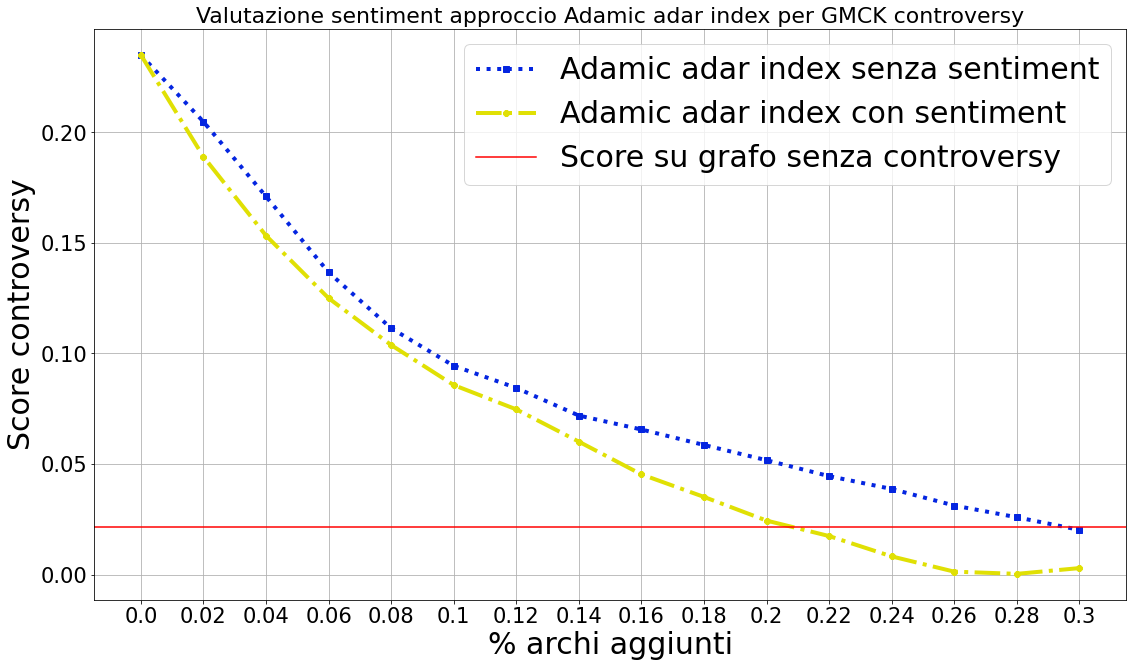

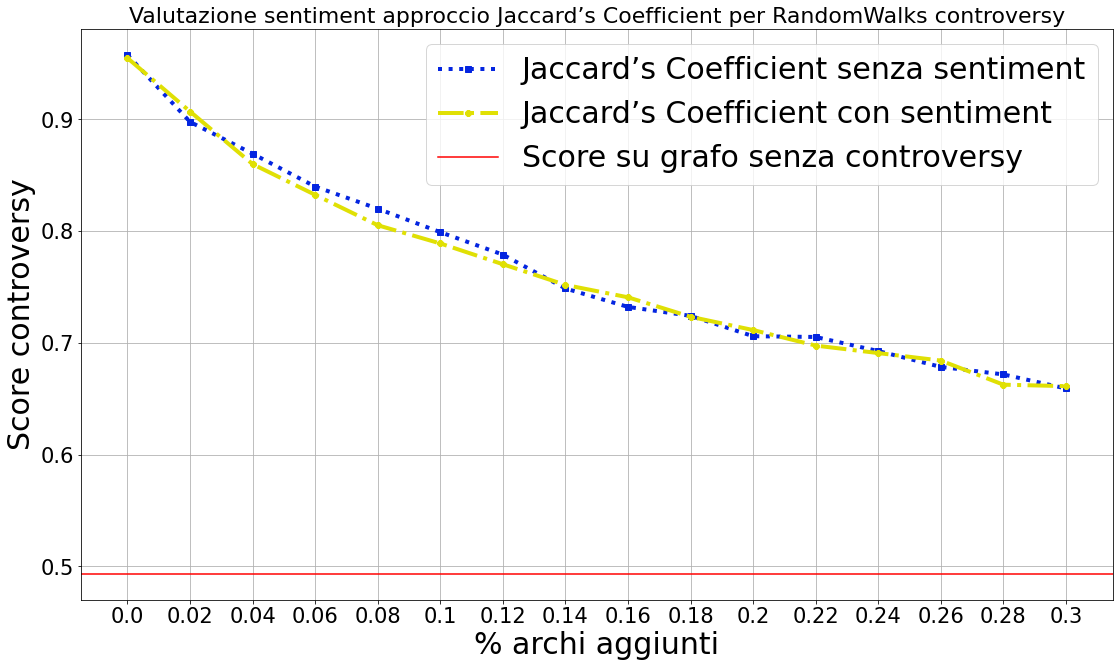

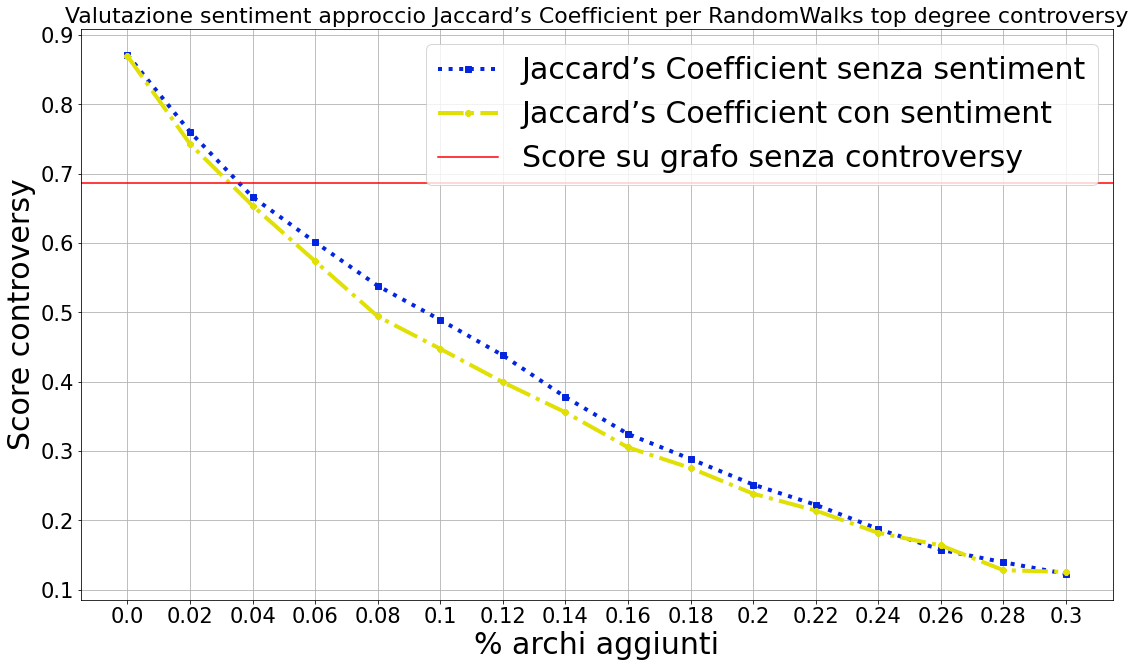

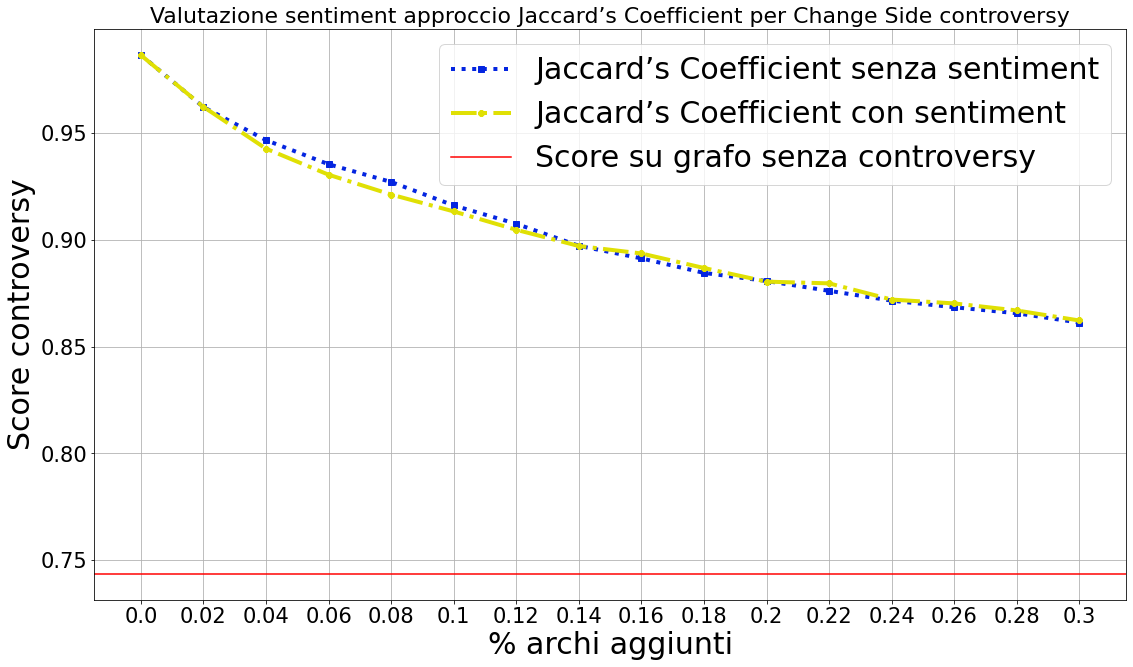

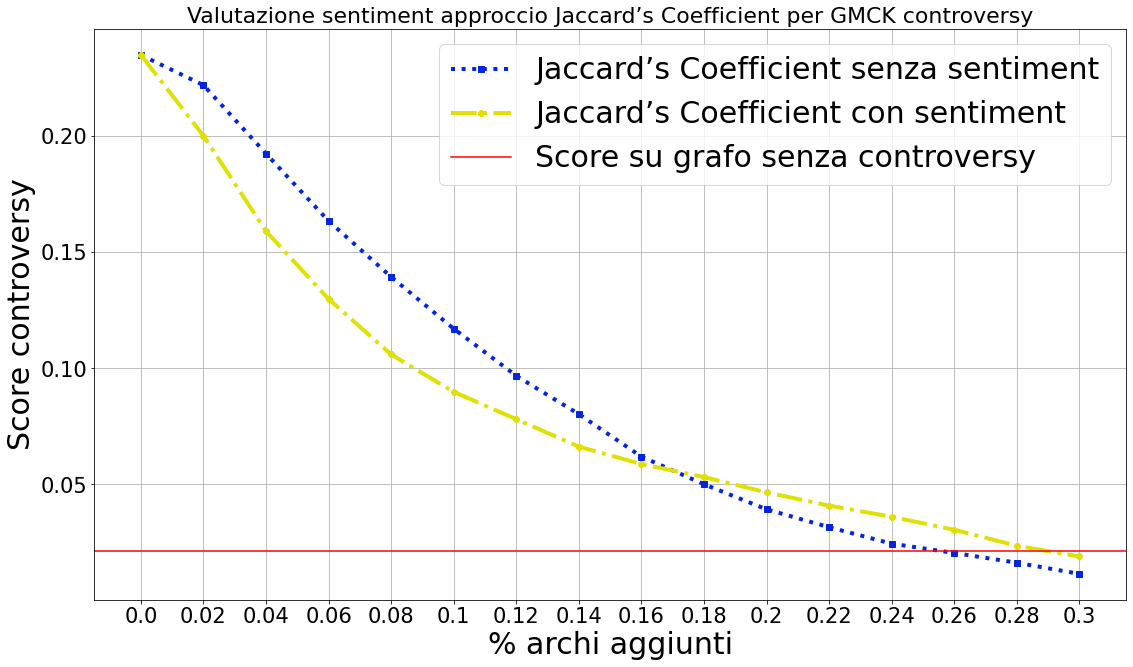

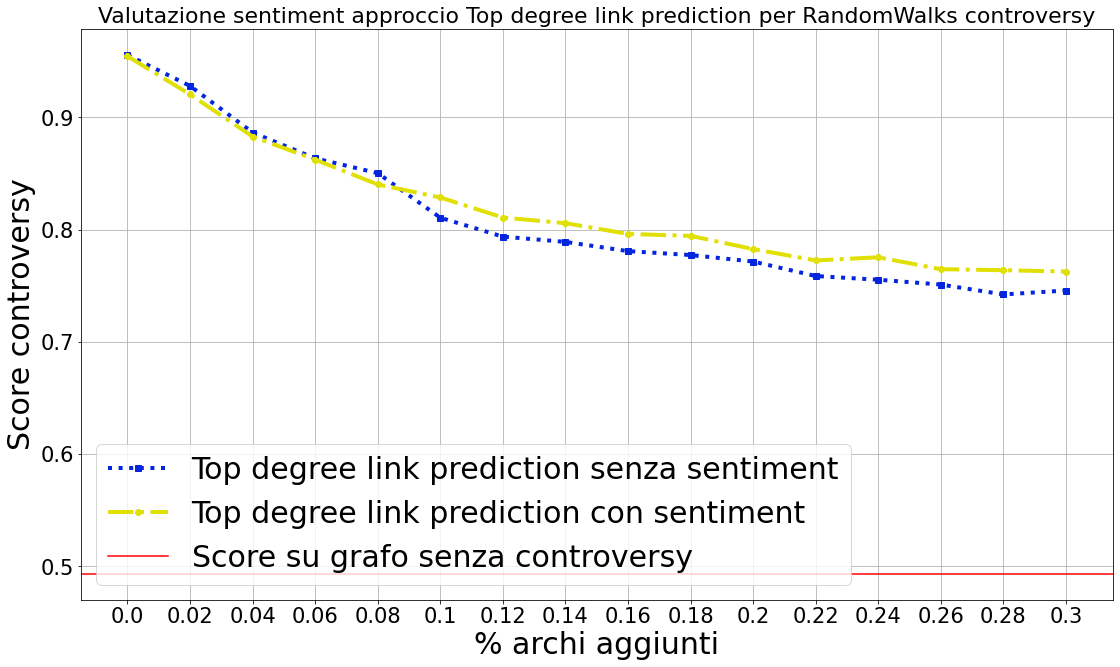

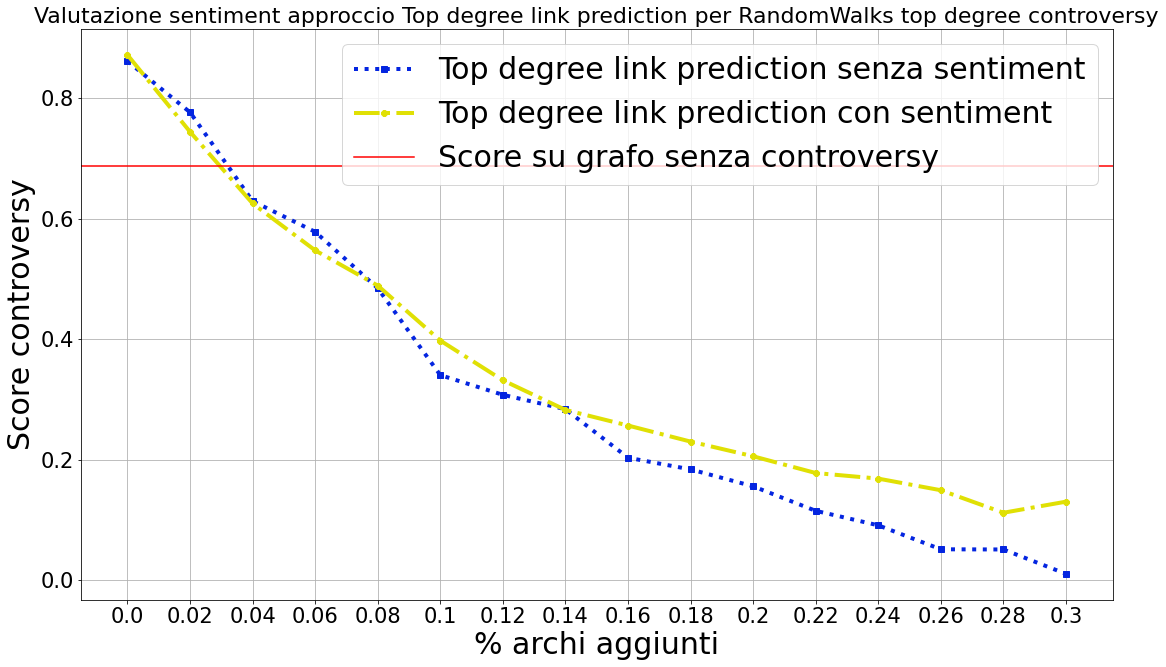

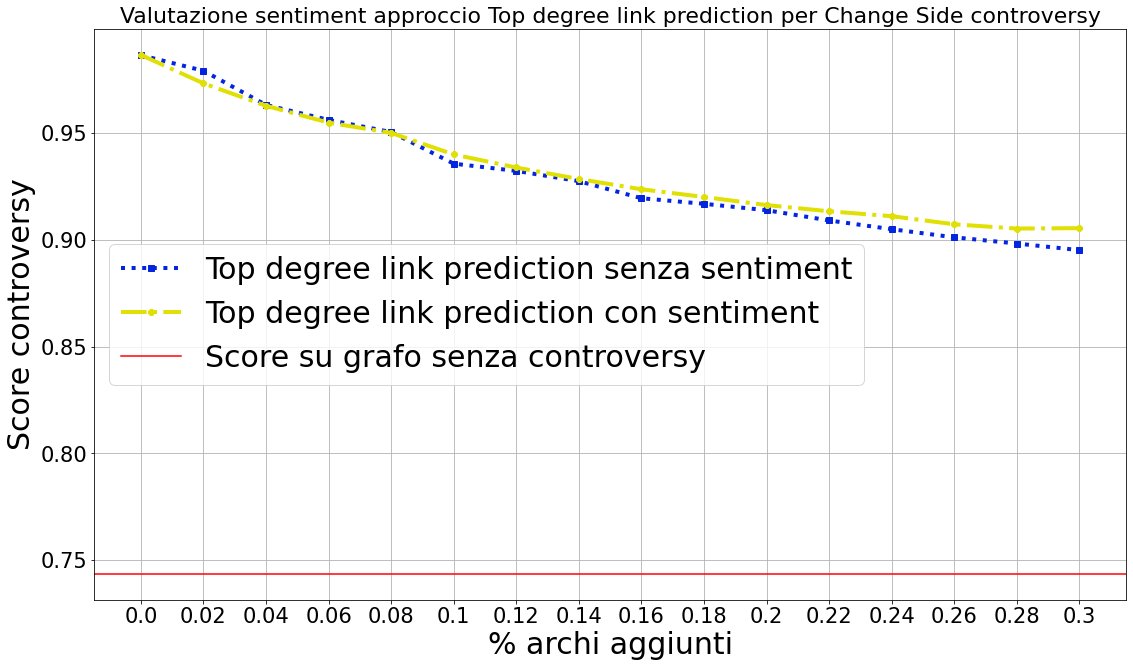

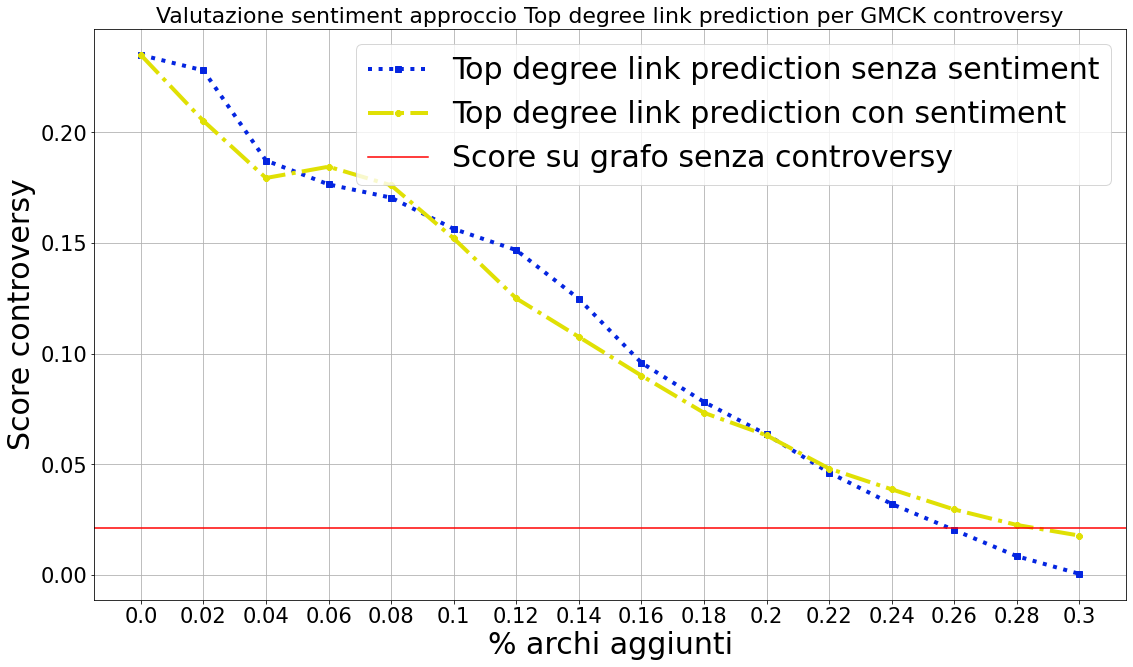

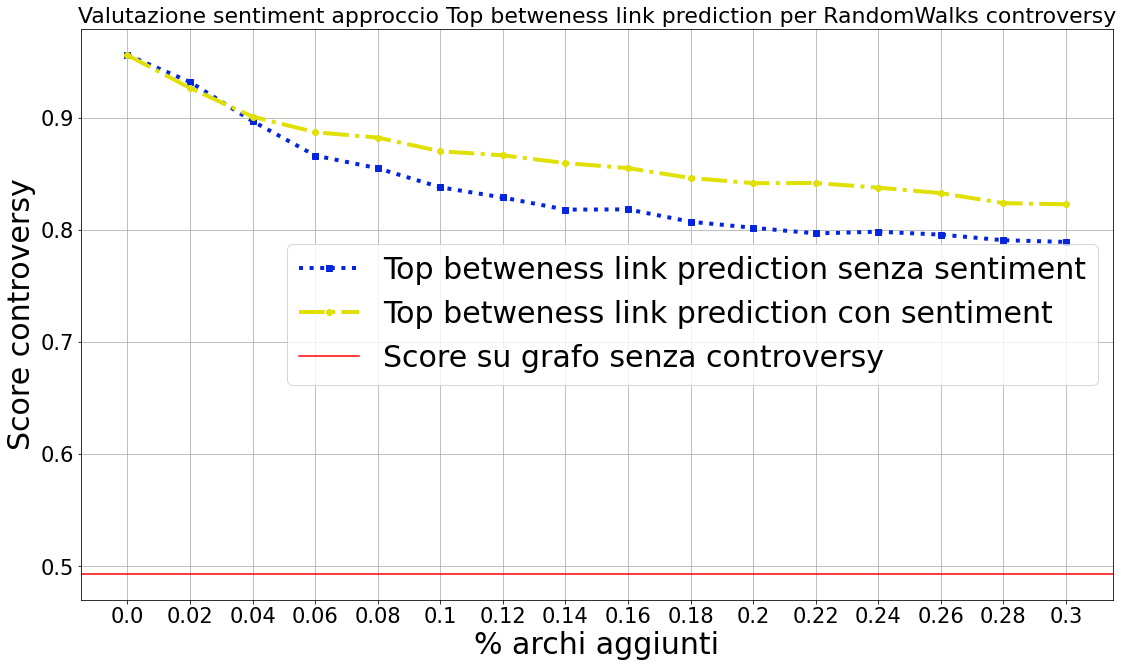

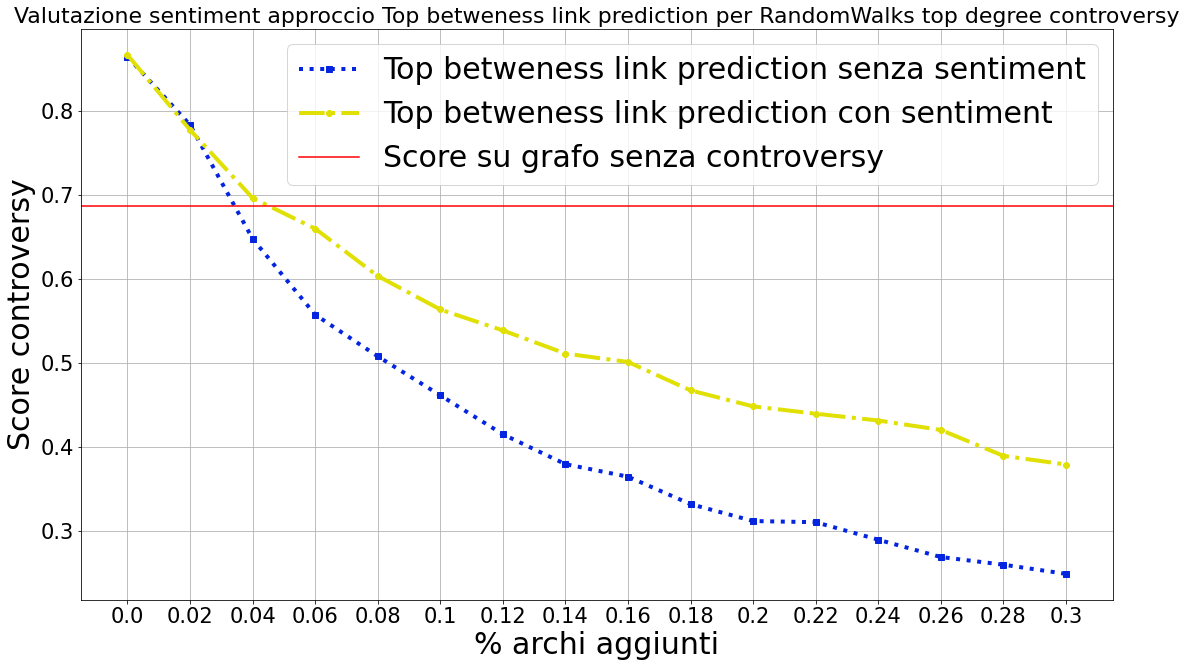

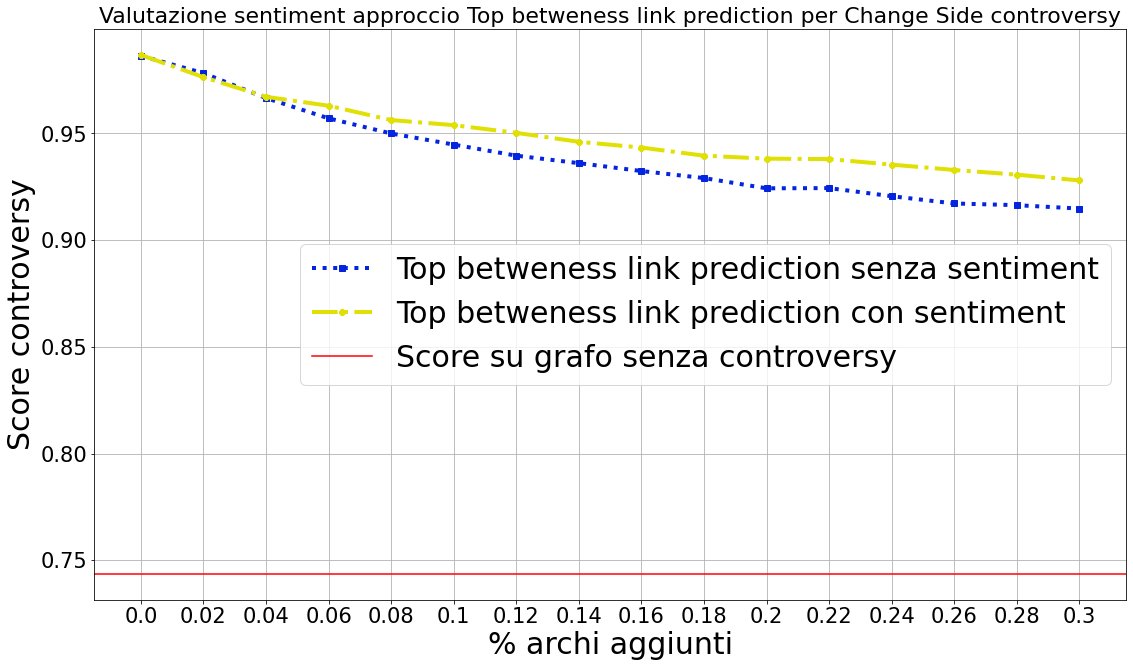

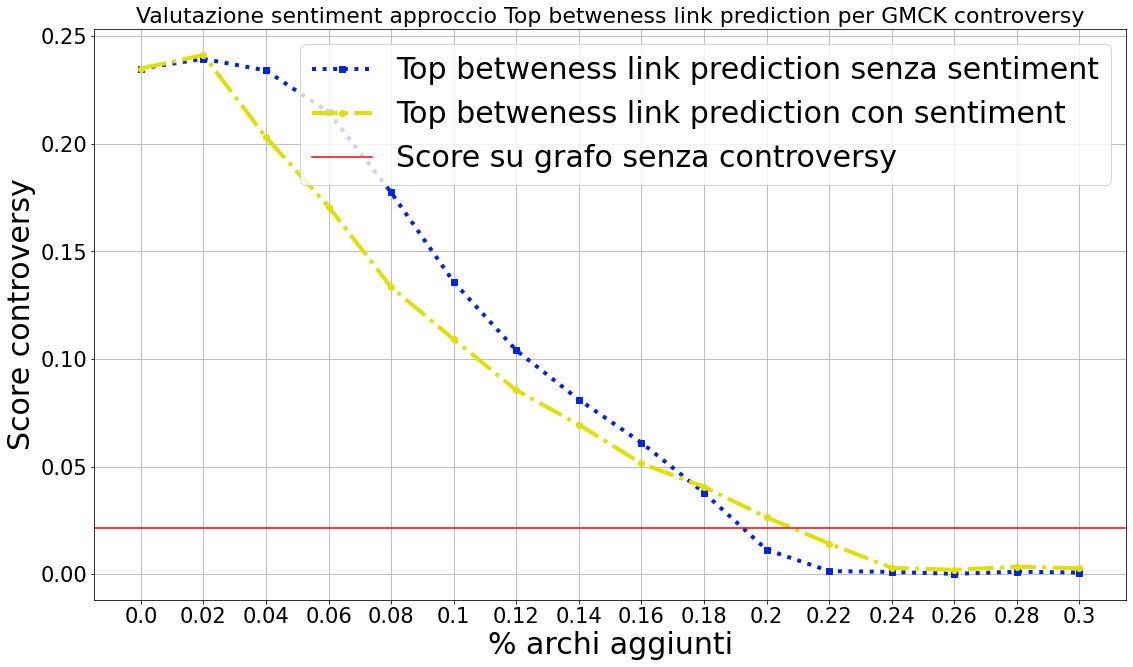

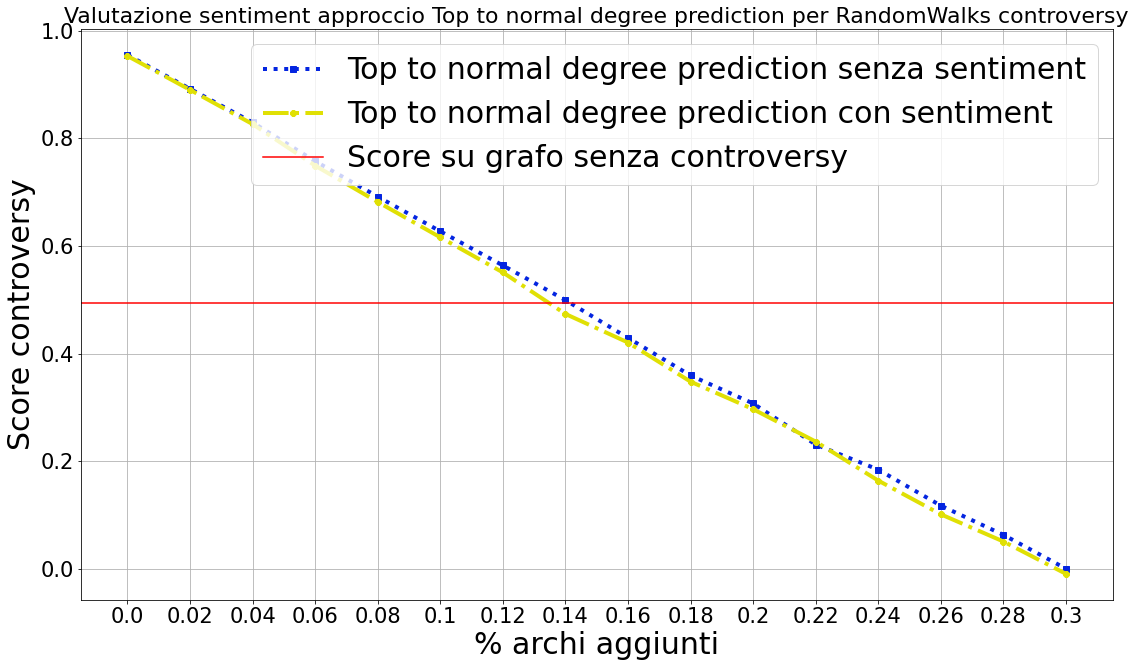

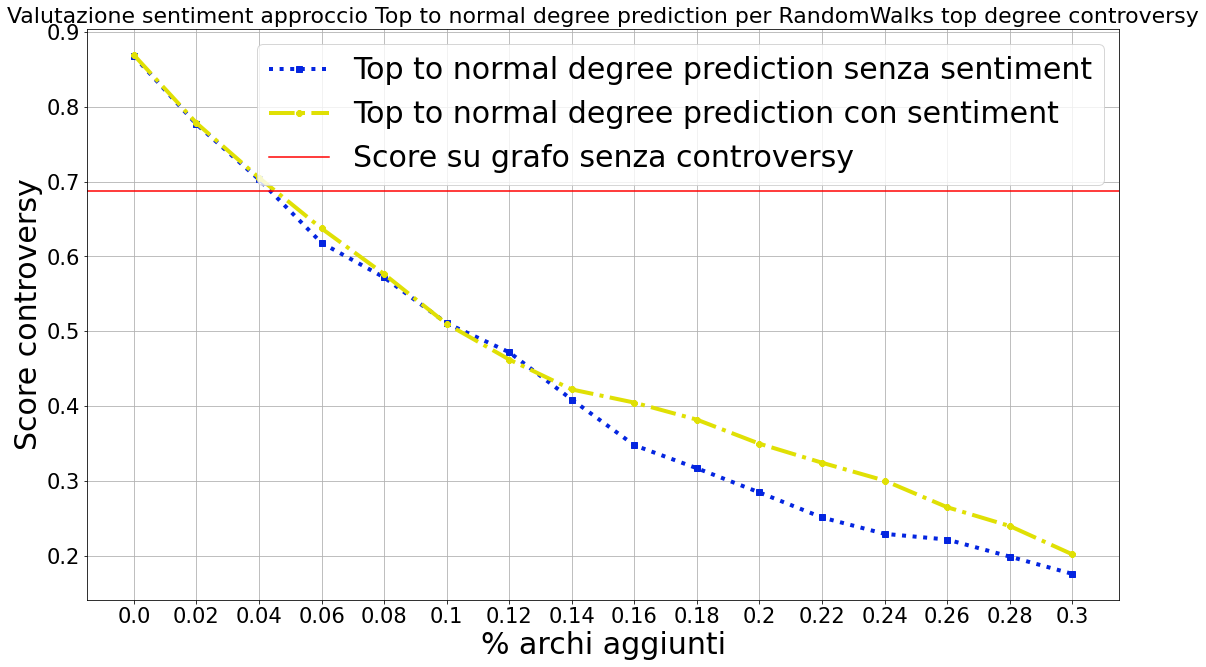

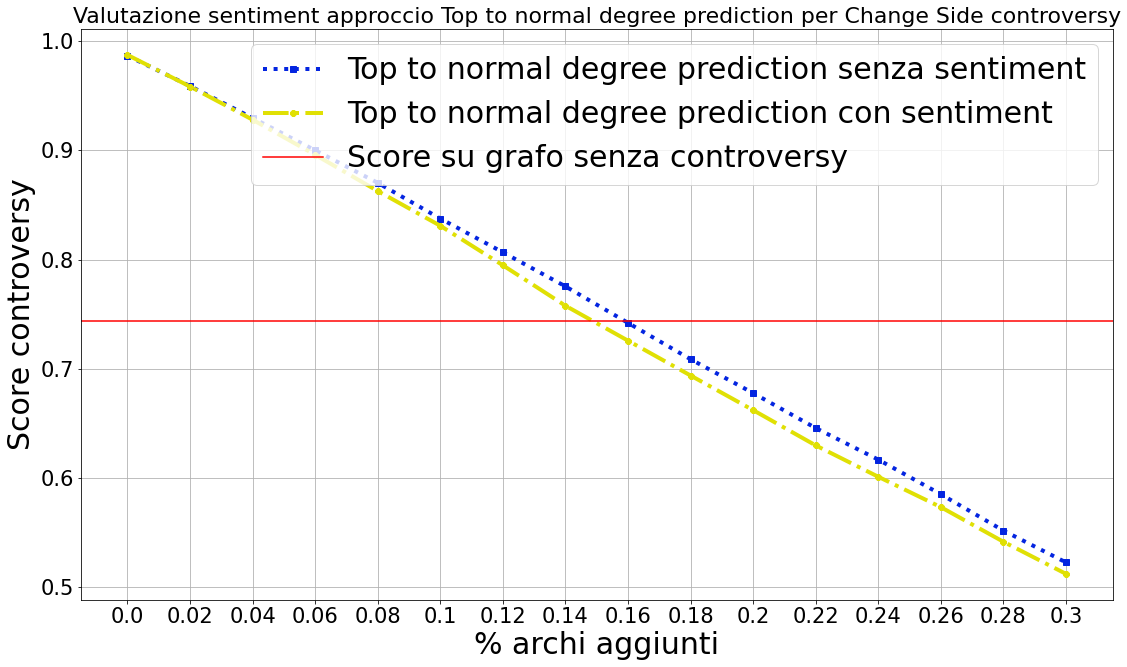

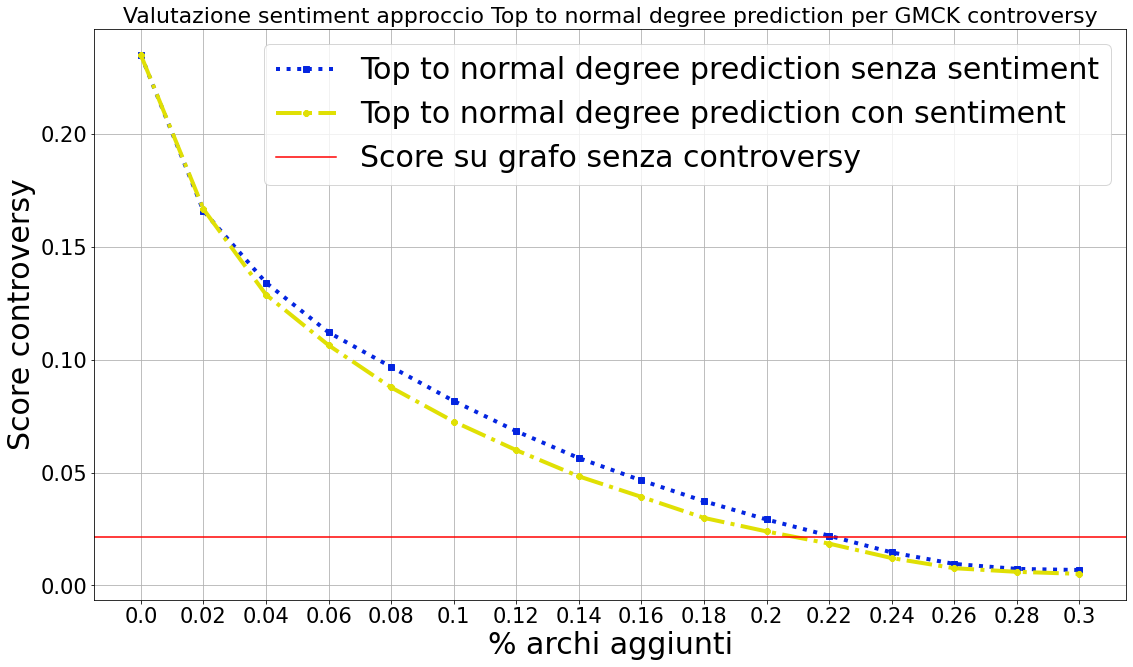

In [7]:
contr_detect_method = ['RandomWalks', 'RandomWalks top degree', 'Change Side', 'GMCK']
labels = ['Adamic adar index', 'Jaccard’s Coefficient', 'Top degree link prediction', 'Top betweness link prediction', 'Top to normal degree prediction']
no_contr_values = [0.4933, 0.6869,  0.7436, 0.0213]

for i in range(len(result_no_sent)):
    # for each controversy measure
    for j in range(len(result_no_sent[i])):
        plot_controversy_sentiment_match(result_no_sent[i][j], result_sent[i][j], f'Valutazione sentiment approccio {labels[i]} per {contr_detect_method[j]} controversy',  no_contr_values[j], labels[i])

In [5]:
def plot_controversy_sentiment_match(no_sent, sent, title, no_contr_value, methodology):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    marker = ["s", "8"]
    colors = ['#0425e0', '#e0e004']
    x_values = list()
    linestyle = [':', '-.']
    labels = [f'{methodology} senza sentiment', f'{methodology} con sentiment']
    
    k = 0
    for i in range(0, len(no_sent)):
        x_values.append(k/100)
        k += 2

    x_indexes = np.arange(len(x_values))
    
    #print(x_indexes)
    #print(no_sent)
    ax.plot(x_indexes, no_sent, color=colors[0], marker=marker[0], linestyle=linestyle[0], label=labels[0], linewidth=4)
    ax.plot(x_indexes, sent, color=colors[1], marker=marker[1], linestyle=linestyle[1], label=labels[1], linewidth=4)
        
    ax.axhline(no_contr_value, color='#ff0000', label='Score su grafo senza controversy')
    ax.set_xlabel('% archi aggiunti', fontsize=30)
    ax.set_ylabel('Score controversy', fontsize=30)
    ax.set_title(title, fontsize=22)
    ax.legend(prop={"size":30})
    
    plt.xticks(ticks=x_indexes, labels=x_values)
    
    ax.xaxis.set_tick_params(labelsize=21)
    ax.yaxis.set_tick_params(labelsize=21)
    

    plt.grid(True)

    plt.savefig(f'./Riduzione_Controversy_sentiment/{title}.png', dpi = 300, quality = 95, format = 'png', pad_inches = 1000)


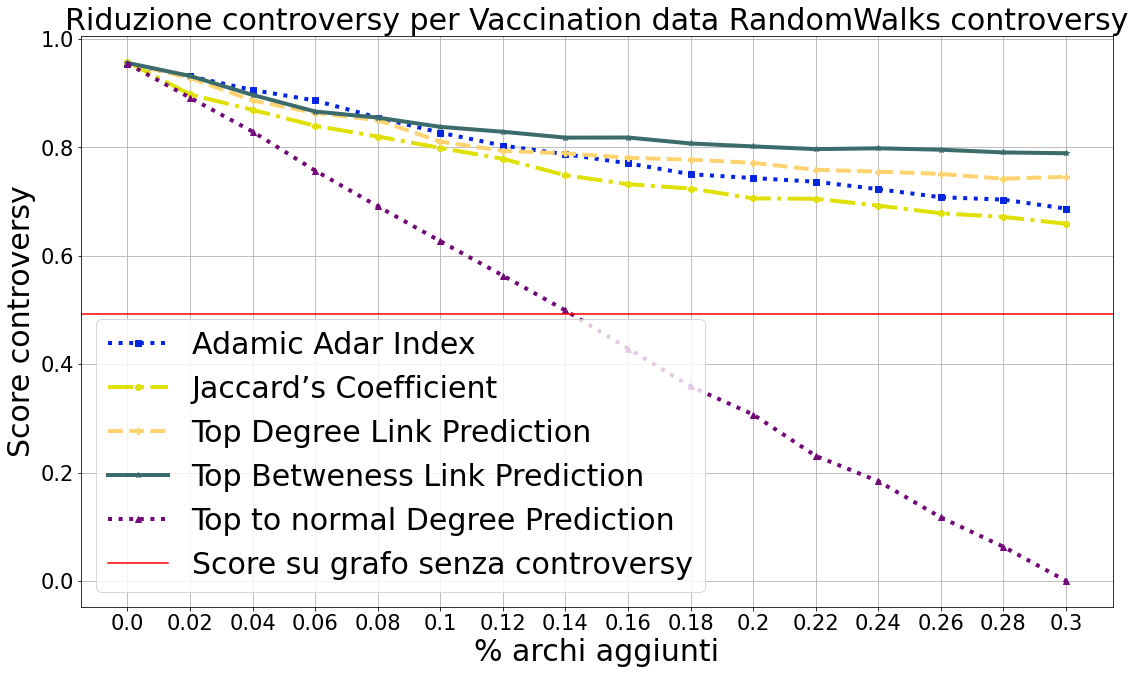

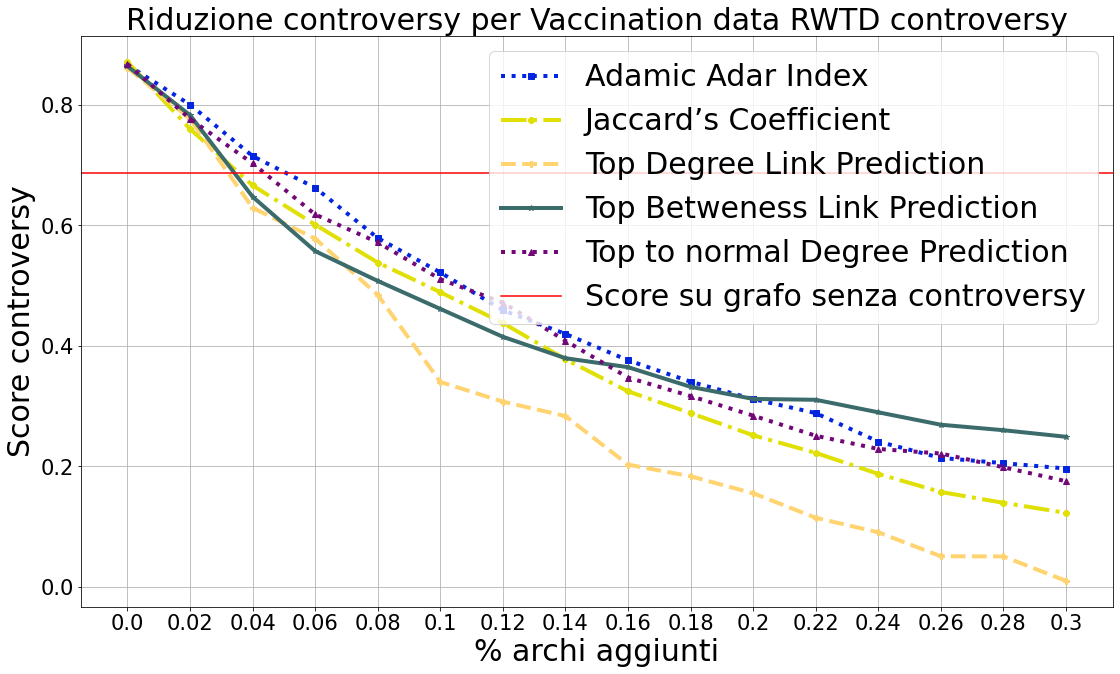

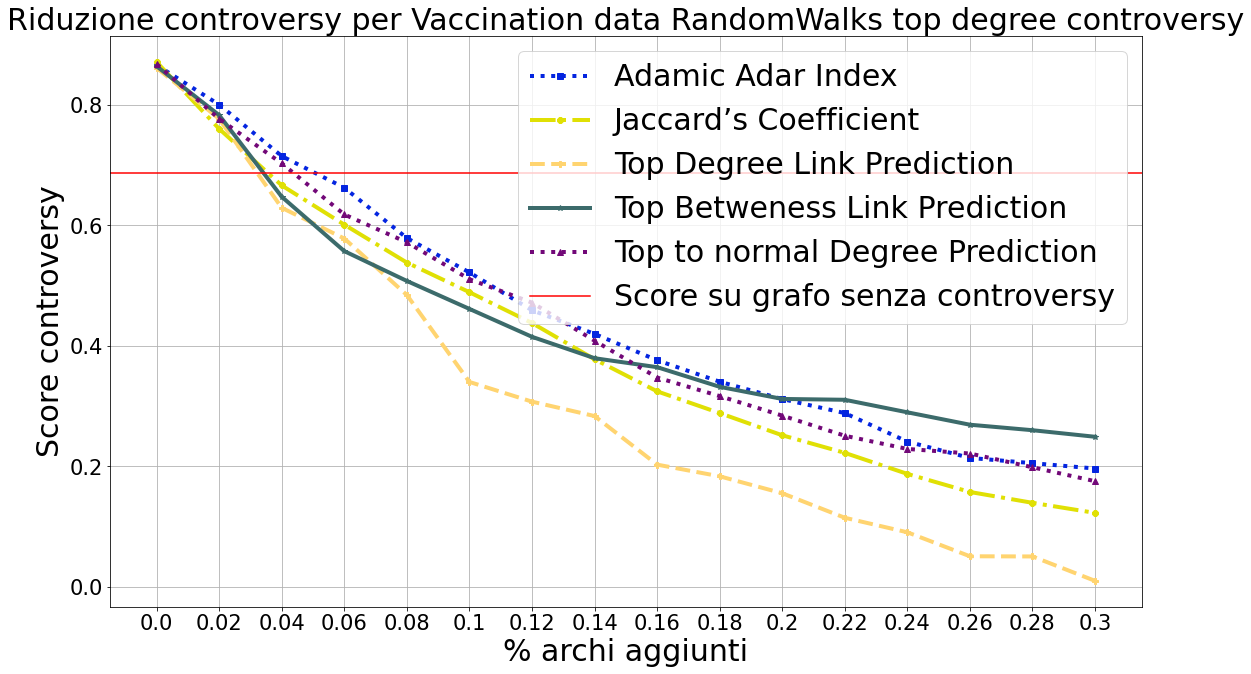

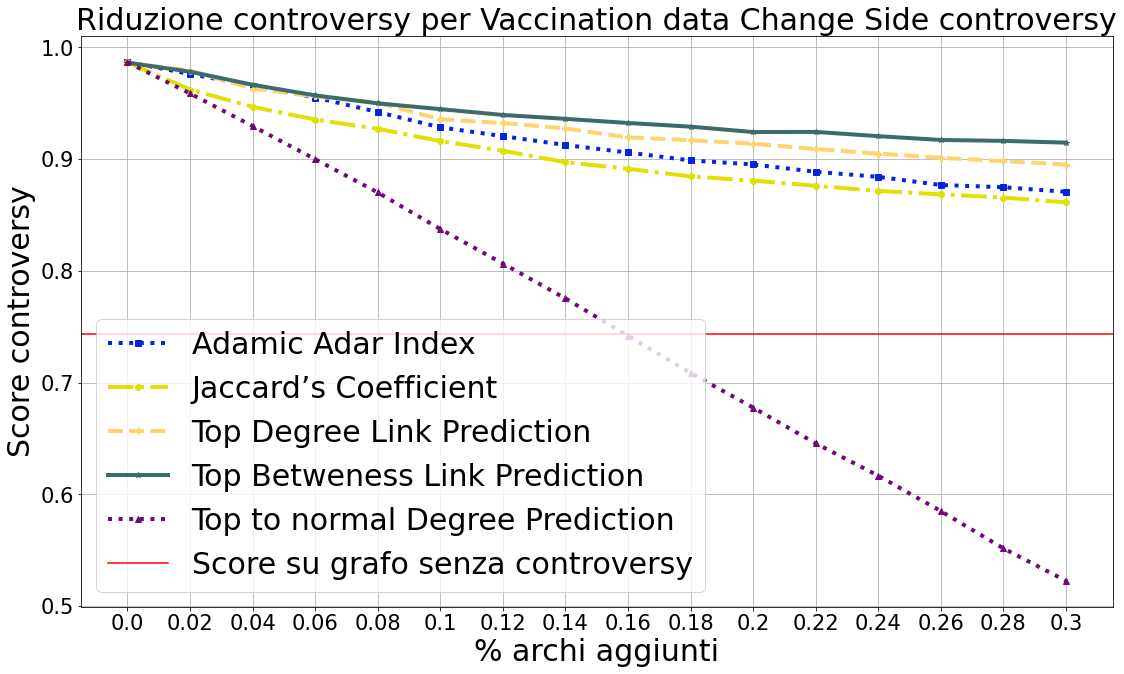

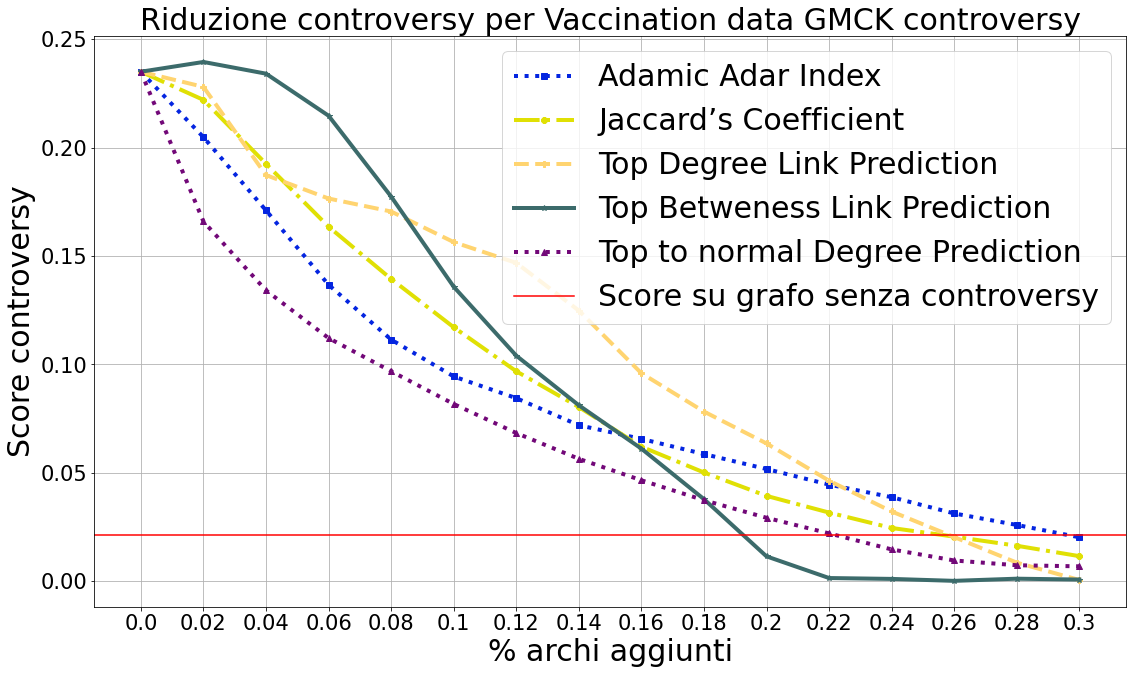

In [9]:
for i in range(4):
    single_target = list()
    for j in range(len(result_no_sent)):
        single_target.append(result_no_sent[j][i])
    if 'RandomWalks top degree' in contr_detect_method[i]:
        plot_controversy_measure_line(single_target, f'Riduzione controversy per Vaccination data RWTD controversy', no_contr_values[i])
    plot_controversy_measure_line(single_target, f'Riduzione controversy per Vaccination data {contr_detect_method[i]} controversy', no_contr_values[i])

In [6]:
def plot_controversy_measure_line(values, title, no_contr_value):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    marker = ["s", "8", "P", "*", "^", "."]
    colors = ['#0425e0', '#e0e004', '#ffd470', '#3c6b6b', '#720878']
    x_values = list()
    linestyle = [':', '-.', '--', '-', ':', '-.']
    labels = ['Adamic Adar Index', 'Jaccard’s Coefficient', 'Top Degree Link Prediction', 'Top Betweness Link Prediction', 'Top to normal Degree Prediction']
    
    k = 0
    for _ in range(0, len(values[0])):
        x_values.append(k/100)
        k += 2

    x_indexes = np.arange(len(x_values))

    #print(x_indexes)
    #print(values[0])
    
    for contr_value in values:
        index = values.index(contr_value)
        ax.plot(x_indexes, contr_value, color=colors[index], marker=marker[index], linestyle=linestyle[index], label=labels[index], linewidth=4)
        
    ax.axhline(no_contr_value, color='#ff0000', label='Score su grafo senza controversy')
    ax.set_xlabel('% archi aggiunti', fontsize=30)
    ax.set_ylabel('Score controversy', fontsize=30)

    ax.set_title(title, fontsize=30)
    ax.legend(prop={"size":30})
    
    plt.xticks(ticks=x_indexes, labels=x_values)
    ax.xaxis.set_tick_params(labelsize=21)
    ax.yaxis.set_tick_params(labelsize=21)

    plt.grid(True)

    plt.savefig(f'./Riduzione_Controversy/{title}.png', dpi = 300, quality = 95, format = 'png', pad_inches = 1000)